In [1]:
import sys
from pathlib import Path
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import ProbabilisticParcellation.functional_profiles as fp
import pandas as pd
import seaborn as sb
import ProbabilisticParcellation.scripts.atlas_paper.feature_model as fm
from ProbabilisticParcellation.scripts.atlas_paper.ridge_reg import ridgeFit
import numpy as np
import os
import ProbabilisticParcellation.util as ut
    

## Explore functional profiles in S1-S4 regions 

In [2]:
Data, regions_all = fm.load_profiles()
tags = fm.load_features()
tags_individ = fm.subject_features(tags, Data)
task_matrix, task_codes = fm.task_indicator(Data)
tags_task = np.concatenate(
    (tags_individ.T.to_numpy(), task_matrix), axis=1)

Data_norm, tags_norm = fm.normalize(Data[regions_all], tags_task)

# Ridge regression
R2, features = ridgeFit(Data_norm.to_numpy(), tags_norm,
                        fit_intercept=False, voxel_wise=False, alpha=1.0)


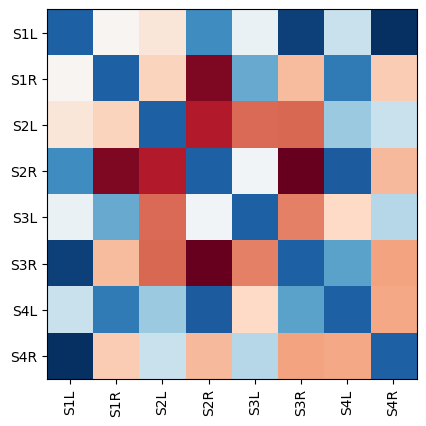

In [3]:
# Correlate profiles between subregions
# Select subregions
regions = ['S1L', 'S1R', 'S2L', 'S2R', 'S3L', 'S3R', 'S4L', 'S4R']
cmap = plt.get_cmap('RdBu_r')
corr = np.corrcoef(Data[regions].to_numpy().T)
# Set diagonal to zero
np.fill_diagonal(corr, 0)
plt.imshow(corr, cmap=cmap)
plt.xticks(np.arange(len(regions)), regions, rotation=90)
plt.yticks(np.arange(len(regions)), regions)
plt.savefig(ut.figure_dir + 'social_network_correlation.pdf', dpi=300)



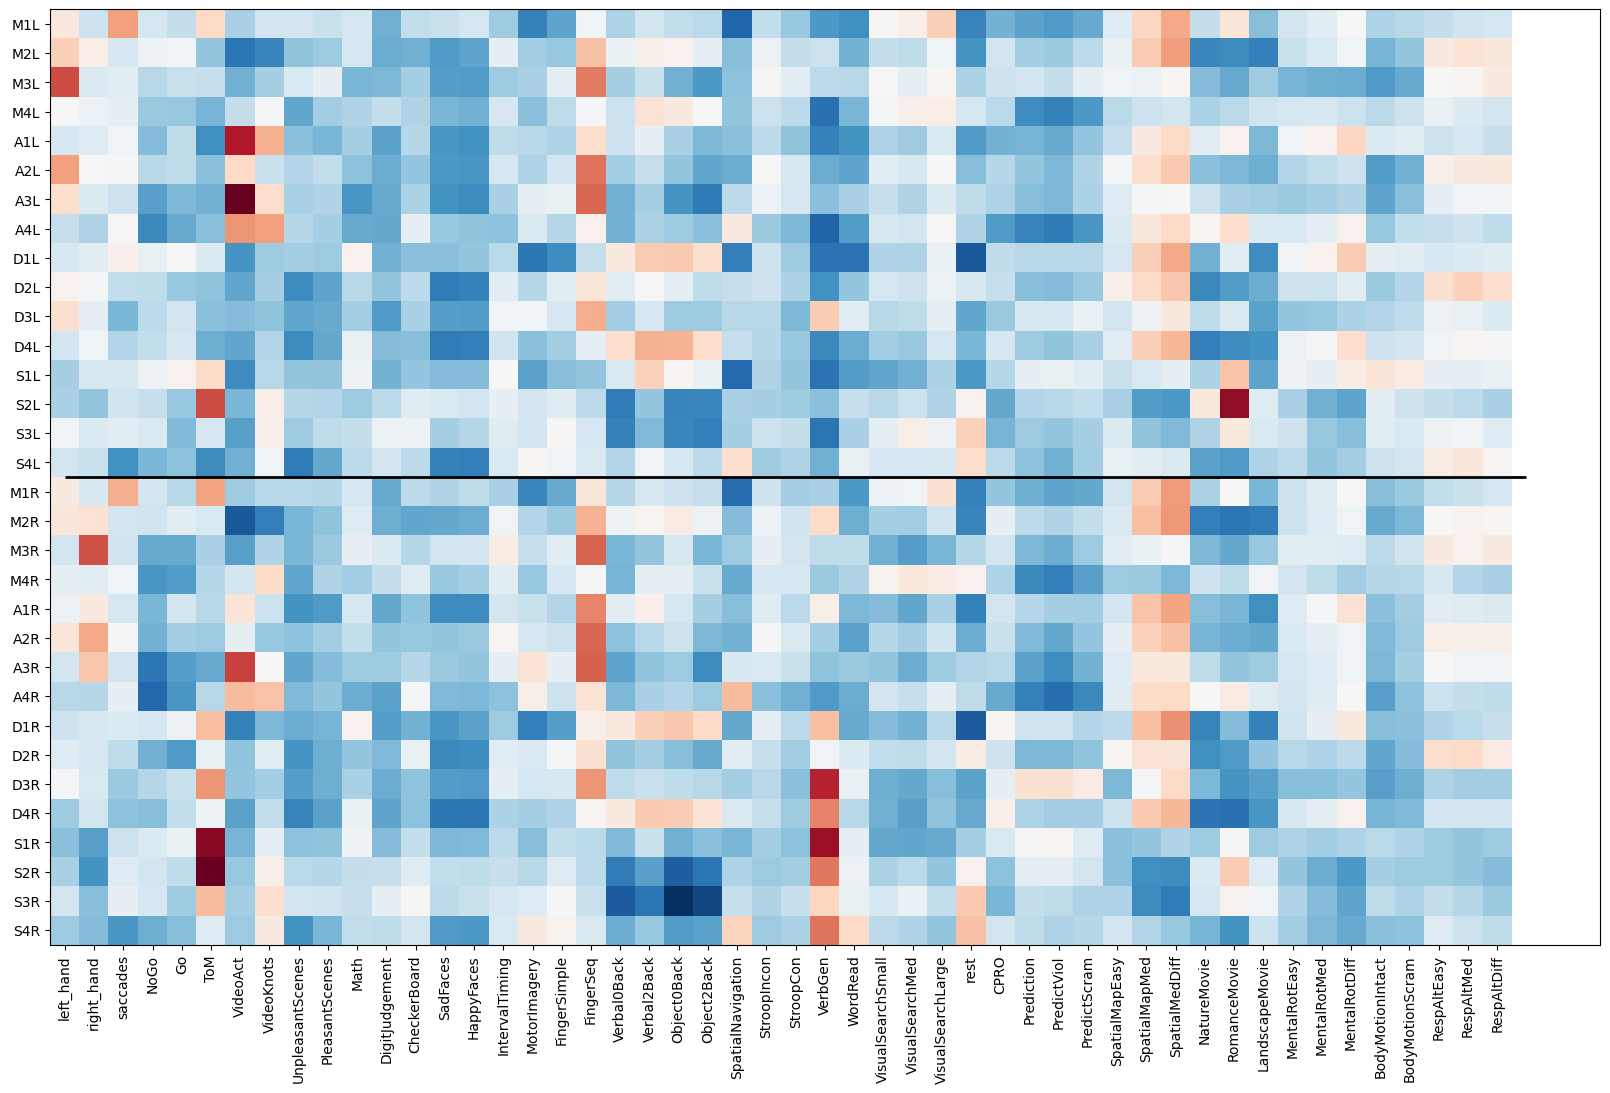

In [4]:
# Make dataframe
Features = pd.DataFrame(features.T, columns=[
    'left_hand', 'right_hand', 'saccades'] + list(task_codes.keys()), index=regions_all)

# Plot
cmap = plt.get_cmap('RdBu_r')
plt.figure(figsize=(20, 20))
plt.imshow(Features, cmap=cmap)
plt.yticks(np.arange(len(regions_all)), regions_all)
plt.xticks(np.arange(len(Features.columns.tolist())),
           Features.columns.tolist(), rotation=90)

# Plot a horizontal line in the middle
plt.hlines(len(regions_all) / 2 - 0.5, 0,
           len(Features.columns.tolist()), color='black', linewidth=2)
plt.savefig(f'{ut.figure_dir}/feature_matrix.pdf', dpi=300)


In [5]:
regions = ['S1L','S1R','S2L','S2R','S3L','S3R','S4L','S4R']
reg_colors = [[0.681,0.2444,0.2878],[1.0,0.4204,0.7005],[0.5,0.3261,1.0],[0.8166,0.1178,0.5079]]

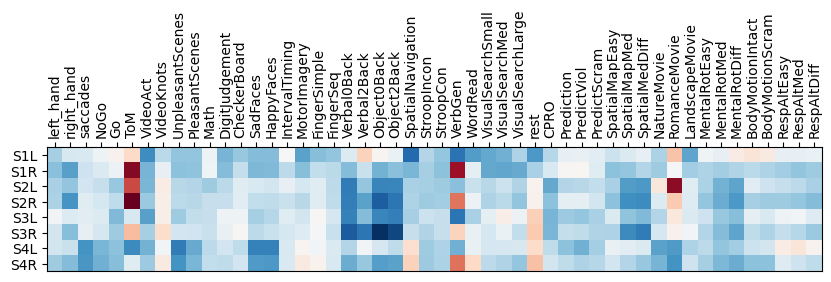

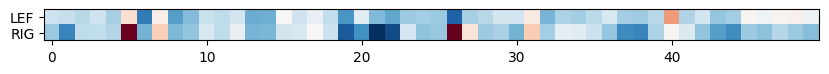

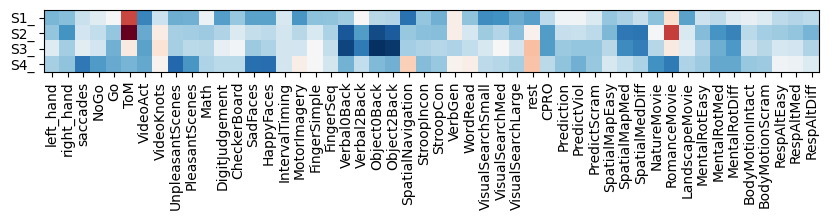

In [6]:
# Only select rows where the region is in the list
Feature_regions = Features.loc[regions]
cmap = plt.get_cmap('RdBu_r')
plt.figure(figsize=(10, 10))
# plt.subplot(3, 1, 1)
plt.imshow(Feature_regions, cmap=cmap)
plt.yticks(np.arange(len(regions)), regions)
plt.xticks(np.arange(len(Features.columns.tolist())),
           Features.columns.tolist(), rotation=90)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)


# Show feature matrix averaged across 'side'
plt.figure(figsize=(10, 10))
# plt.subplot(3,1,2)
plt.imshow(Feature_regions.groupby(Feature_regions.index.str[2:]).mean(), cmap=cmap)
plt.yticks(np.arange(len(Feature_regions.index.str[2:].unique(
))), ['LEF', 'RIG'])

# Show feature matrix averaged across 'side'
plt.figure(figsize=(10, 10))
# plt.subplot(3, 1, 3)
plt.imshow(Feature_regions.groupby(
    Feature_regions.index.str[:2]).mean(), cmap=cmap)
plt.xticks(np.arange(len(Features.columns.tolist())),
              Features.columns.tolist(), rotation=90)
plt.yticks(np.arange(len(Feature_regions.index.str[:2].unique(
))), Feature_regions.index.str[:2].unique() + '_')

plt.savefig(f'{ut.figure_dir}/feature_matrix_social.pdf', dpi=300)

In [7]:
# Melt
T = Feature_regions.reset_index().melt(id_vars='index', value_vars=Features.columns.tolist(),
                         var_name='task', value_name='score')

# make index into column
T['region'] = T['index']
# # Split region into side and region
T['side'] = T.region.str[-1]
T['reg'] = T.region.str[0:2]


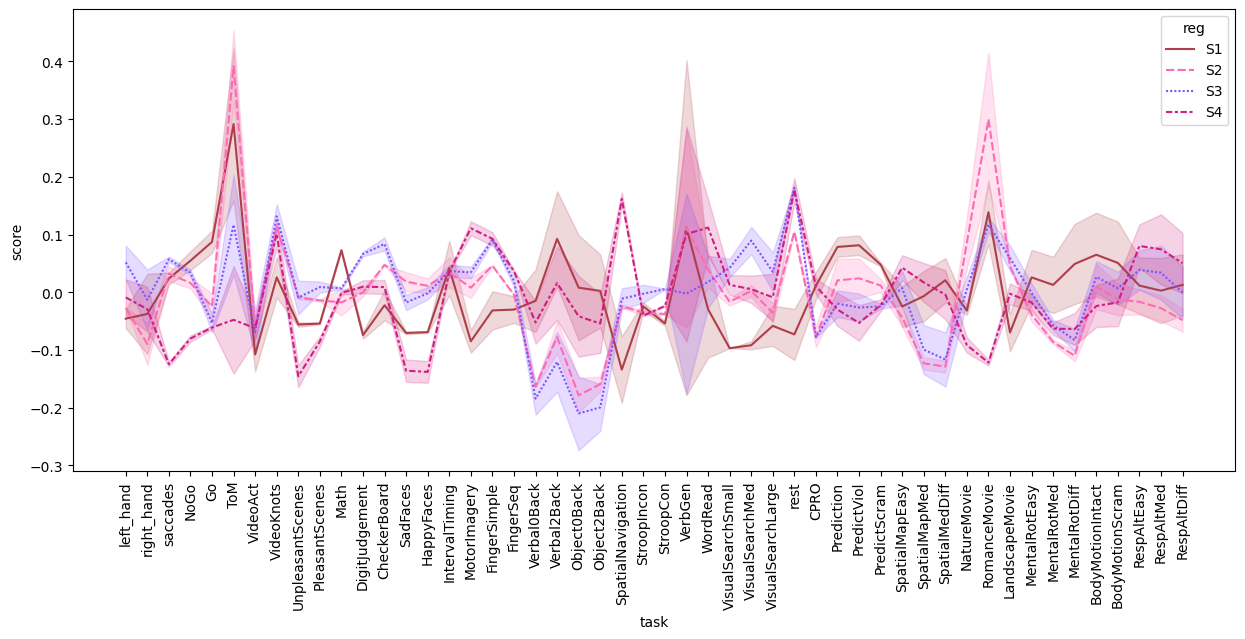

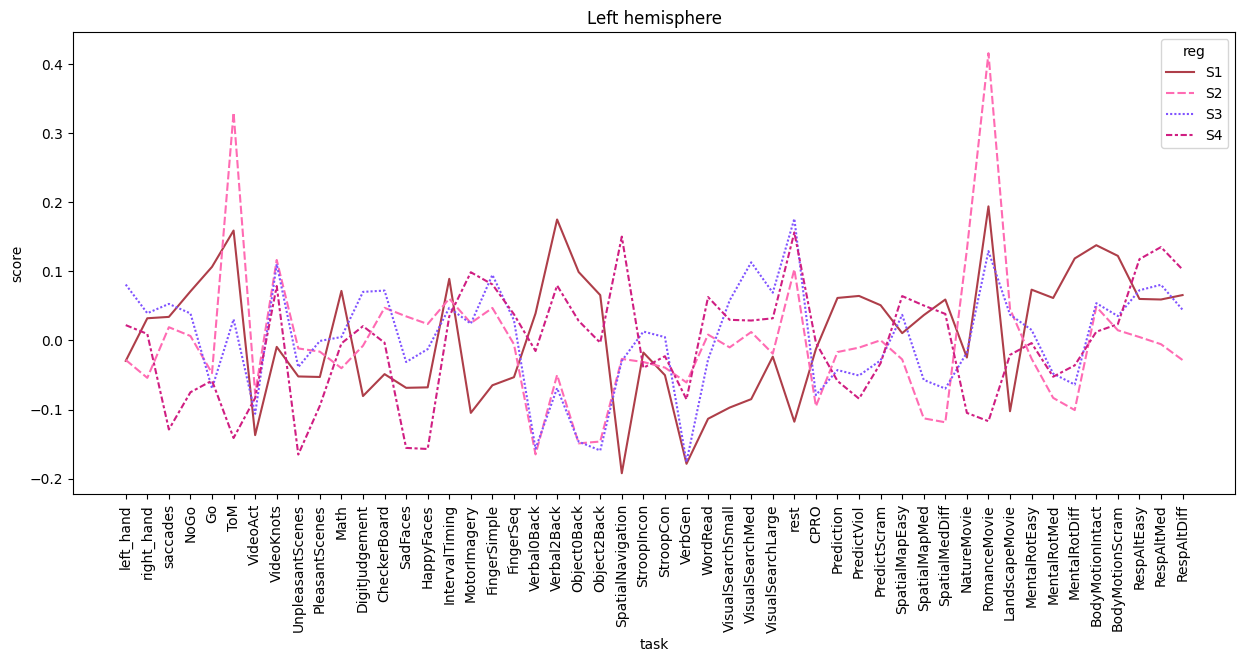

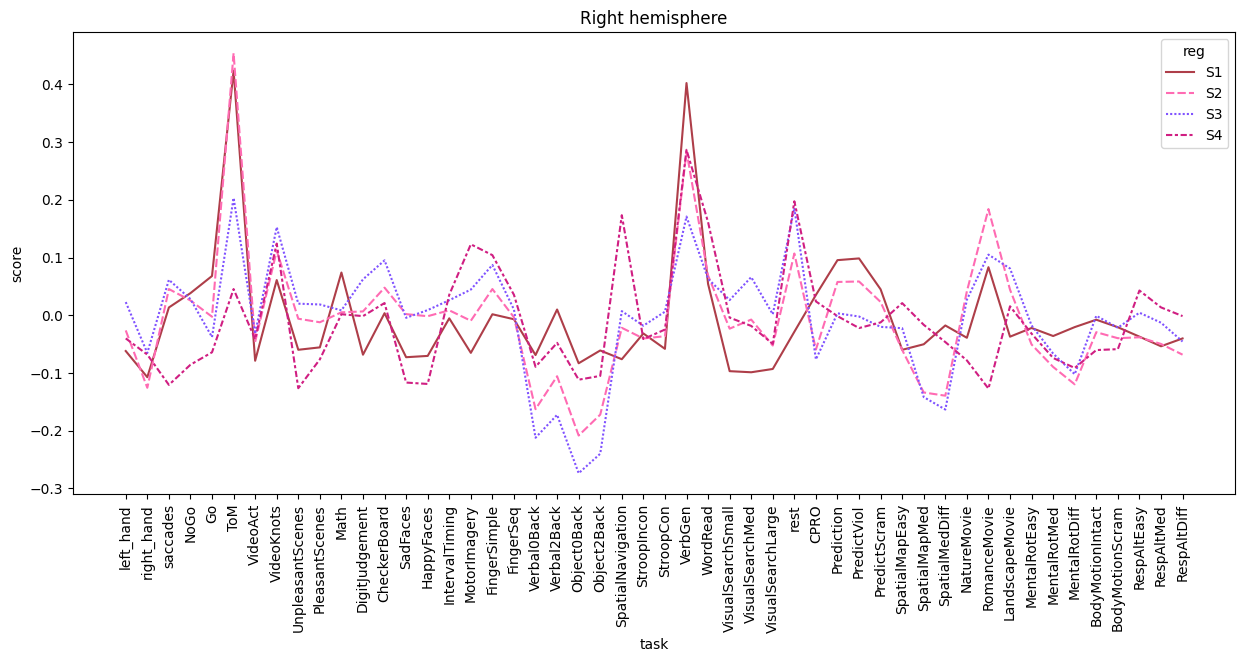

In [8]:
plt.figure(figsize=(15, 6))
sb.lineplot(data=T, x='task', y='score', hue='reg',
            palette=reg_colors, hue_order=['S1', 'S2', 'S3', 'S4'], style='reg')
xt = plt.xticks(rotation=90)

plt.figure(figsize=(15, 6))
sb.lineplot(data=T[T.side=='L'], x='task', y='score', hue='reg',
            palette=reg_colors, hue_order=['S1', 'S2', 'S3', 'S4'], style='reg')
plt.title('Left hemisphere')
xt = plt.xticks(rotation=90)

plt.figure(figsize=(15, 6))
sb.lineplot(data=T[T.side == 'R'], x='task', y='score', hue='reg',
            palette=reg_colors, hue_order=['S1', 'S2', 'S3', 'S4'], style='reg')
plt.title('Right hemisphere')
xt = plt.xticks(rotation=90)


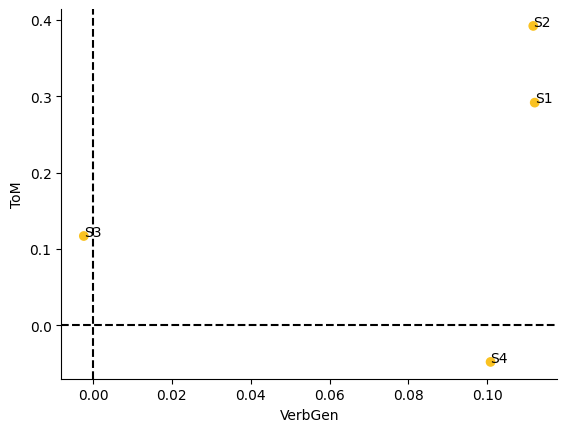

In [9]:
# fm.scatter_plot(compare, T.drop(columns=['region', 'index', 'side']))

compare = ['VerbGen', 'ToM']
fm.scatter_plot_tasks(compare, T.drop(columns=['region', 'index', 'side']), ignore_side=True)

# Plot differentiating tasks

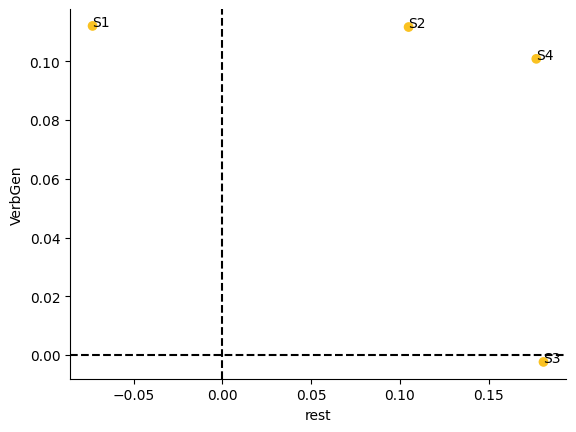

In [15]:
compare = ['rest', 'VerbGen']
fm.scatter_plot_tasks(compare, T, ignore_side=True, color='domains')


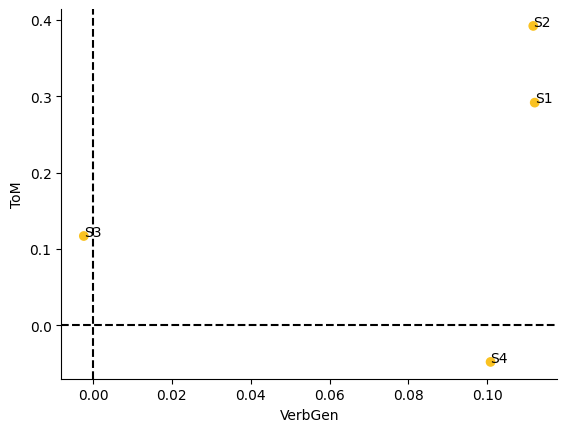

In [16]:
compare = ['VerbGen', 'ToM']
fm.scatter_plot_tasks(compare, T, ignore_side=True)


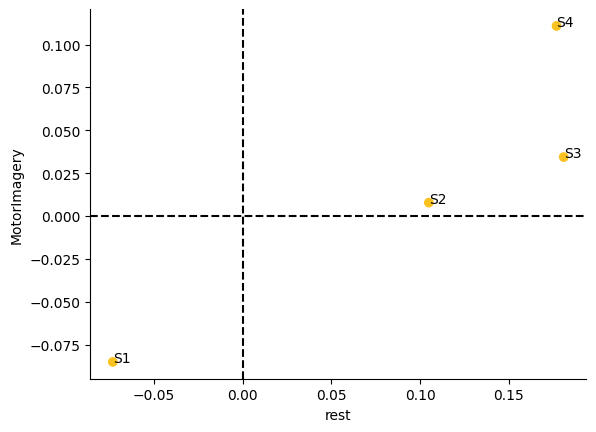

In [17]:
compare = ['rest', 'MotorImagery']
fm.scatter_plot_tasks(compare, T, ignore_side=True)

plt.savefig(
    ut.figure_dir + f'localizers_social_{compare[0]}_{compare[1]}.pdf', dpi=300)


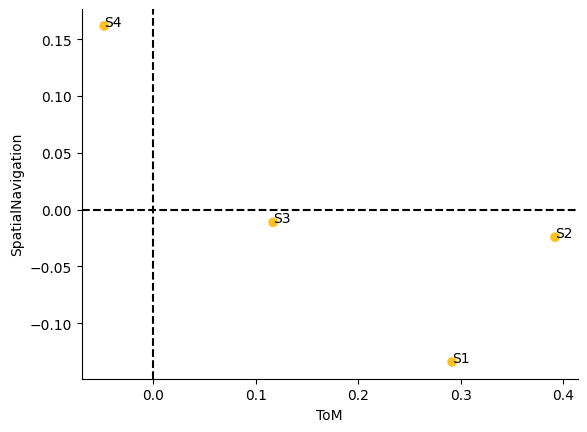

In [18]:
compare = ['ToM', 'SpatialNavigation']
fm.scatter_plot_tasks(compare, T, ignore_side=True)

plt.savefig(
    ut.figure_dir + f'localizers_social_{compare[0]}_{compare[1]}.pdf', dpi=300)


# Tasks that separate out left and right

([<matplotlib.axis.XTick at 0x15c4d71f0>,
 [Text(0, 0, 'left_hand'),
  Text(1, 0, 'right_hand'),
  Text(2, 0, 'saccades'),
  Text(3, 0, 'NoGo'),
  Text(4, 0, 'Go'),
  Text(5, 0, 'ToM'),
  Text(6, 0, 'VideoAct'),
  Text(7, 0, 'VideoKnots'),
  Text(8, 0, 'UnpleasantScenes'),
  Text(9, 0, 'PleasantScenes'),
  Text(10, 0, 'Math'),
  Text(11, 0, 'DigitJudgement'),
  Text(12, 0, 'CheckerBoard'),
  Text(13, 0, 'SadFaces'),
  Text(14, 0, 'HappyFaces'),
  Text(15, 0, 'IntervalTiming'),
  Text(16, 0, 'MotorImagery'),
  Text(17, 0, 'FingerSimple'),
  Text(18, 0, 'FingerSeq'),
  Text(19, 0, 'Verbal0Back'),
  Text(20, 0, 'Verbal2Back'),
  Text(21, 0, 'Object0Back'),
  Text(22, 0, 'Object2Back'),
  Text(23, 0, 'SpatialNavigation'),
  Text(24, 0, 'StroopIncon'),
  Text(25, 0, 'StroopCon'),
  Text(26, 0, 'VerbGen'),
  Text(27, 0, 'WordRead'),
  Text(28, 0, 'VisualSearchSmall'),
  Text(29, 0, 'VisualSearchMed'),
  Text(30, 0, 'VisualSearchLarge'),
  Text(31, 0, 'rest'),
  Text(32, 0, 'CPRO'),
  Text(33

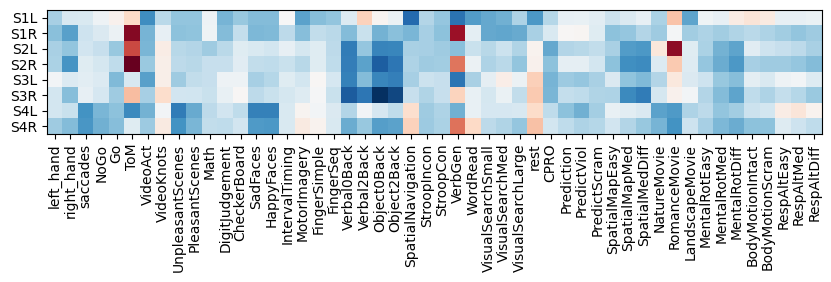

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(Features.loc[regions], cmap=cmap)
plt.yticks(np.arange(len(regions)), regions)
plt.xticks(np.arange(len(Features.columns.tolist())),
           Features.columns.tolist(), rotation=90)


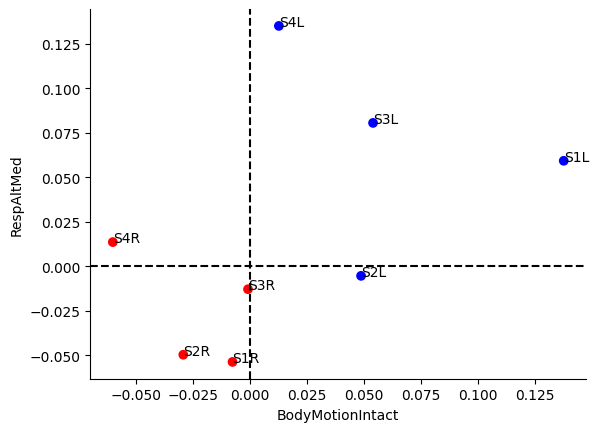

In [20]:
compare = ['BodyMotionIntact', 'RespAltMed']
fm.scatter_plot_tasks(compare, T, ignore_side=False, color='hemispheres')


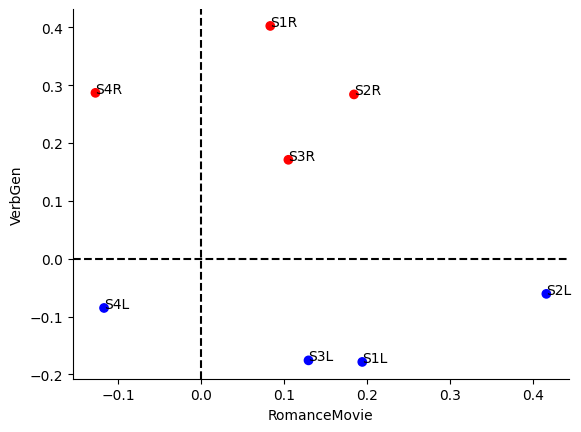

In [21]:
compare = ['RomanceMovie', 'VerbGen']
fm.scatter_plot_tasks(compare, T, ignore_side=False, color='hemispheres')
plt.savefig(ut.figure_dir + f'localizers_social_{compare[0]}_{compare[1]}_hemispheres.pdf', dpi=300)
